In [1]:
%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt

# convert from arcseconds to radians
arcsec = np.pi / (180.0 * 3600) # [radians]  = 1/206265 radian/arcsec

# PyMC3 in the Fourier Plane

Let's take a gander at implementing a PyMC3 model to sample a visibility model. 

$$
    I(\alpha, \delta |\, \boldsymbol{\beta}) = a \exp \left [ - \left \{  \frac{(\alpha^\prime - \delta_\alpha)^2}{2 \sigma_\alpha^2} + \frac{(\delta^\prime - \delta_\delta)^2}{2 \sigma_\delta^2} \right \} \right ]
$$

then the model visibility function (via Fourier transform pairs) is

$$
    V(u, v |\, \boldsymbol{\beta}) = 2 \pi a \sigma_\alpha \sigma_\delta \exp \left [ -2 \pi^2 (\sigma_\alpha^2 u^{\prime 2} + \sigma_\delta^2 v^{\prime 2}) - 2 \pi i (\delta_\alpha u^\prime + \delta_\alpha v^\prime)\right ].
$$

Let's implement this sky plane model 

In [2]:
def sky_plane(alpha, dec, a=1, delta_alpha=0.0, delta_dec=0.0, sigma_alpha=1.0*arcsec, 
              sigma_delta=1.0*arcsec, Omega=0.0):
    '''
    a : amplitude
    delta_alpha : offset (in radians)
    delta_dec : offset (in radians)
    sigma_alpha : width (in radians)
    sigma_dec : width (in radians)
    Omega : position angle of ascending node (in degrees east of north)
    '''
    
    return a * np.exp(-( (alpha - delta_alpha)**2/(2 * sigma_alpha**2) + \
                        (dec - delta_dec)**2/(2 * sigma_delta**2)))

In [3]:
def fftspace(width, N):
    '''Oftentimes it is necessary to get a symmetric coordinate array that spans ``N``
     elements from `-width` to `+width`, but makes sure that the middle point lands
     on ``0``. The indices go from ``0`` to ``N -1.``
     `linspace` returns  the end points inclusive, wheras we want to leave out the
     right endpoint, because we are sampling the function in a cyclic manner.'''

    assert N % 2 == 0, "N must be even."

    dx = width * 2.0 / N
    xx = np.empty(N, np.float)
    for i in range(N):
        xx[i] = -width + i * dx
    
    return xx

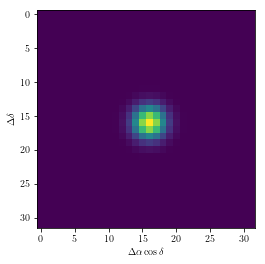

In [5]:
# Let's plot this up and see what it looks like 

N_alpha = 32 
N_dec = 32 
img_radius = 10.0 * arcsec


# full span of the image
ra = fftspace(img_radius, N_alpha) # [arcsec]
dec = fftspace(img_radius, N_dec) # [arcsec]

# fill out an image 
img = np.empty((N_dec, N_alpha), np.float)

for i,dec in enumerate(dec):
    for j,alpha in enumerate(ra):
        img[i,j] = sky_plane(alpha, dec)

plt.imshow(img, origin="upper", interpolation="none", aspect="equal")
plt.xlabel(r"$\Delta \alpha \cos \delta$");
plt.ylabel(r"$\Delta \delta$");

Now, let's FFT this to get a visibility domain version. First, we'll need to `fftshift` everything so we don't get phase-offsets. 

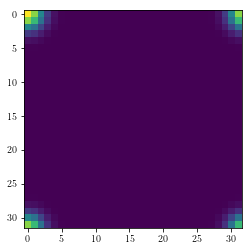

In [6]:
plt.imshow(np.fft.fftshift(img), origin="upper", interpolation="none", aspect="equal");

In [7]:
vis = np.fft.fft2(np.fft.fftshift(img))

In [ ]:
# plot the real, imaginary, amplitude, and phase of these 


In [10]:
np.meshgrid(ra, dec)


(1, 32)

In [ ]:
# Implement the full sky-to-visibility model in Theano

# I think we want the grid of alphas for evaluation to be a shared variable

# a : amplitude
# delta_alpha : offset (in radians)
# delta_delta : offset (in radians)
# sigma_alpha : width (in radians)
# sigma_delta : width (in radians)

# update a shared variable
# data.set_value(data_vals)

# create input grid as a shared variable
# NOTE that these must be `fftshifted` already.
alpha = theano.shared(np.fft.fftshift(ras[np.newaxis,:]))
# calculate dalpha, the space between the grids  
dalpha = abs(alpha[0,1] - alpha[0,0])

a = tt.scalar("a")
delta_alpha = tt.scalar("delta_alpha")
sigma_alpha = tt.scalar("sigma_alpha")

I = a * tt.exp(-(alpha - delta_alpha)**2/(2 * sigma_alpha**2))
# since the input coordinates were already shifted, then this is too

rfft = dalpha * fft.rfft(I, norm=None)
# rshape = tt.shape(rfft)
# fshape = theano.function([alpha, a, delta_alpha, sigma_alpha], rshape)

f_vis = theano.function([a, delta_alpha, sigma_alpha], rfft)